<a href="https://colab.research.google.com/github/BasselKhalid/Thesis/blob/main/Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

Load and Clean the Dataset

In [2]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
from IPython.display import display  # ✅ Ensures display() works properly

# Load and clean dataset
df = pd.read_csv("shopping_trends.csv")
df = df.drop(columns=["Customer ID"])
df = df.drop_duplicates()

# Show missing values
print("🔍 Missing Values:")
print(df.isnull().sum()[df.isnull().sum() > 0])

# Show structure
print("\n📄 Data Sample:")
display(df.head())  # 👈 Properly rendered in Colab

print("\n🧾 Data Types:")
print(df.dtypes)

# Show descriptive statistics
print("\n📊 Data Description:")
display(df.describe())


Saving shopping_trends.csv to shopping_trends (9).csv
🔍 Missing Values:
Series([], dtype: int64)

📄 Data Sample:


,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Preferred Payment Method,Frequency of Purchases
0,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Credit Card,Express,Yes,Yes,14,Venmo,Fortnightly
1,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Bank Transfer,Express,Yes,Yes,2,Cash,Fortnightly
2,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Cash,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,PayPal,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Cash,Free Shipping,Yes,Yes,31,PayPal,Annually



🧾 Data Types:
Age                           int64
Gender                       object
Item Purchased               object
Category                     object
Purchase Amount (USD)         int64
Location                     object
Size                         object
Color                        object
Season                       object
Review Rating               float64
Subscription Status          object
Payment Method               object
Shipping Type                object
Discount Applied             object
Promo Code Used              object
Previous Purchases            int64
Preferred Payment Method     object
Frequency of Purchases       object
dtype: object

📊 Data Description:


,Age,Purchase Amount (USD),Review Rating,Previous Purchases
count,3900.000000,3900.000000,3900.000000,3900.000000
mean,44.068462,59.764359,3.749949,25.351538
std,15.207589,23.685392,0.716223,14.447125
min,18.000000,20.000000,2.500000,1.000000
25%,31.000000,39.000000,3.100000,13.000000
50%,44.000000,60.000000,3.700000,25.000000
75%,57.000000,81.000000,4.400000,38.000000
max,70.000000,100.000000,5.000000,50.000000


Identify Feature Types

In [3]:
numerical_features = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = df.select_dtypes(include=["object"]).columns.tolist()

Encode Categorical Features

In [4]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_cats = pd.DataFrame(encoder.fit_transform(df[categorical_features]))
encoded_cats.columns = encoder.get_feature_names_out(categorical_features)
encoded_cats.index = df.index

df_encoded = pd.concat([df[numerical_features], encoded_cats], axis=1)



Preprocessing Pipelines



In [5]:
# Pipeline A
pipeline_a = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", MinMaxScaler())
])
data_a = pipeline_a.fit_transform(df_encoded)

# Pipeline B
pipeline_b = Pipeline([
    ("imputer", KNNImputer(n_neighbors=5)),
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95))
])
data_b = pipeline_b.fit_transform(df_encoded)

# Pipeline C
scaler_c = StandardScaler()
scaled_numerical = scaler_c.fit_transform(df[numerical_features])
Q1 = np.percentile(scaled_numerical, 25, axis=0)
Q3 = np.percentile(scaled_numerical, 75, axis=0)
IQR = Q3 - Q1
mask = ~((scaled_numerical < (Q1 - 1.5 * IQR)) | (scaled_numerical > (Q3 + 1.5 * IQR))).any(axis=1)
df_c_filtered = df_encoded[mask]
data_c_scaled = scaler_c.fit_transform(df_c_filtered)
selector = VarianceThreshold(threshold=0.01)
data_c = selector.fit_transform(data_c_scaled)

# Pipeline D
imputer_d = SimpleImputer(strategy="most_frequent")
data_d_imputed = imputer_d.fit_transform(df_encoded)
data_d_scaled = RobustScaler().fit_transform(data_d_imputed)
data_d = PCA(n_components=0.95).fit_transform(data_d_scaled)



Apply K-Means Clustering

In [6]:
kmeans_a = KMeans(n_clusters=5, random_state=42, n_init=10).fit(data_a)
kmeans_b = KMeans(n_clusters=5, random_state=42, n_init=10).fit(data_b)
kmeans_c = KMeans(n_clusters=5, random_state=42, n_init=10).fit(data_c)
kmeans_d = KMeans(n_clusters=5, random_state=42, n_init=10).fit(data_d)

labels_a = kmeans_a.labels_
labels_b = kmeans_b.labels_
labels_c = kmeans_c.labels_
labels_d = kmeans_d.labels_


PCA Cluster Plots

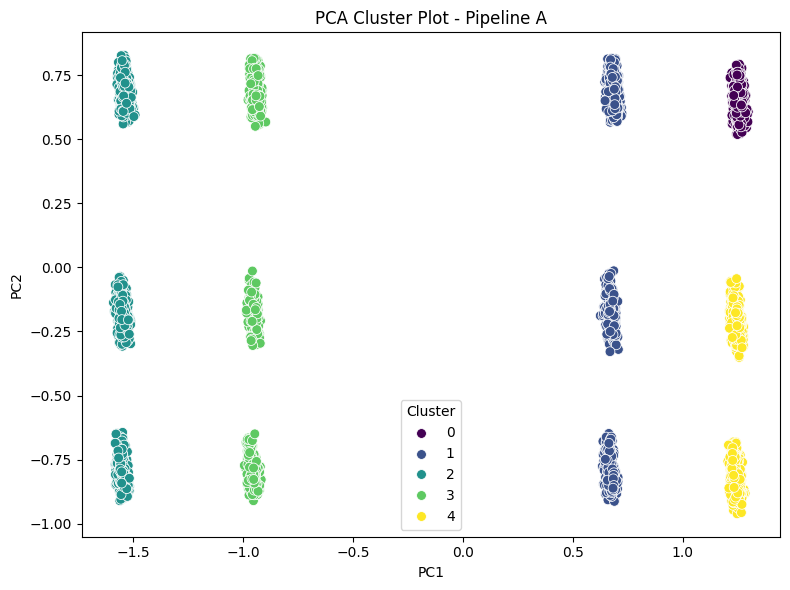

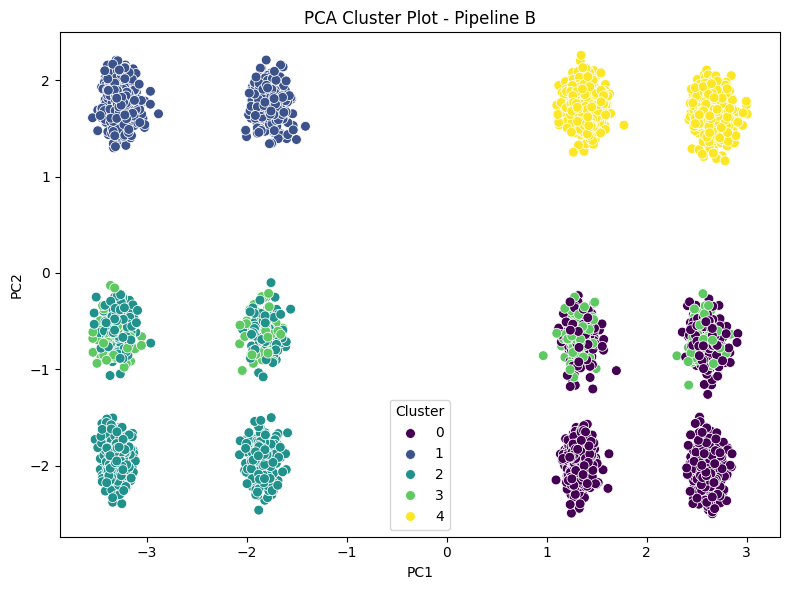

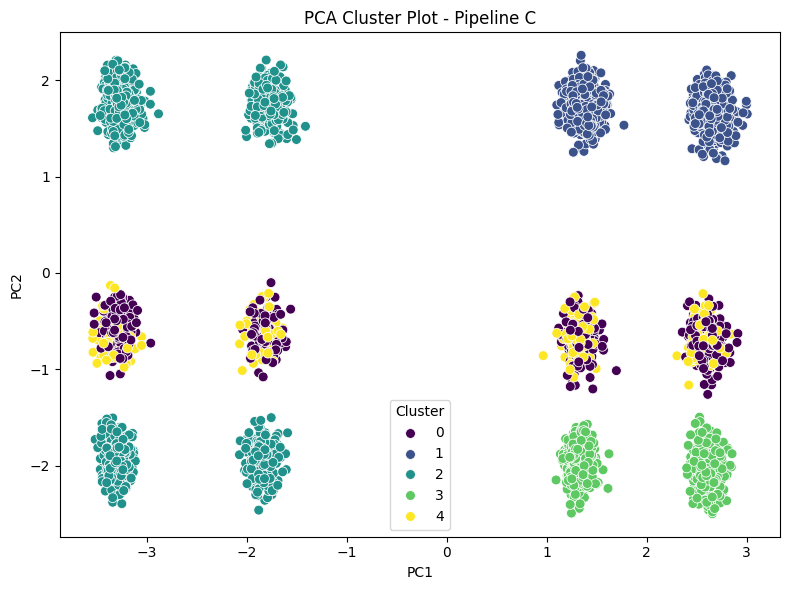

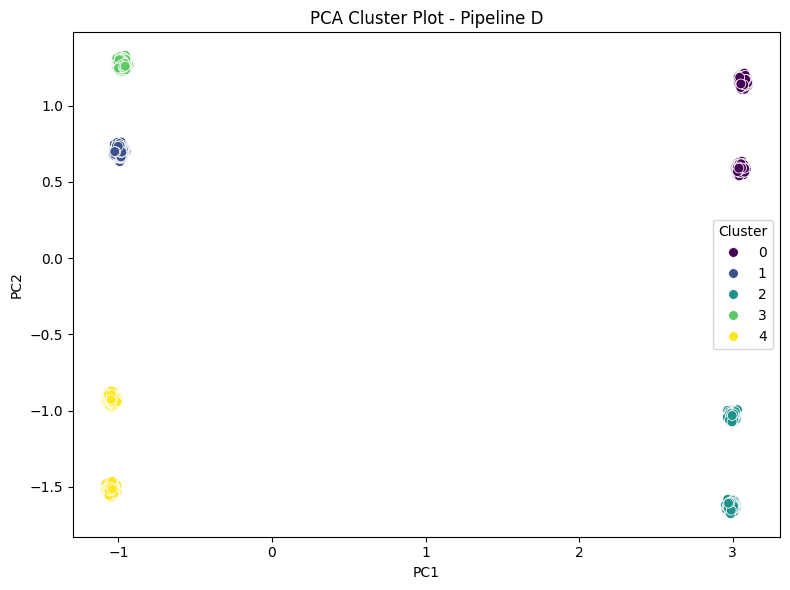

In [7]:
def plot_pca_clusters(data, labels, title):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(data)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=labels, palette='viridis', s=50)
    plt.title(f"PCA Cluster Plot - {title}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()

plot_pca_clusters(data_a, labels_a, "Pipeline A")
plot_pca_clusters(data_b, labels_b, "Pipeline B")
plot_pca_clusters(data_c, labels_c, "Pipeline C")
plot_pca_clusters(data_d, labels_d, "Pipeline D")



Evaluate Clustering Performance

In [8]:
silhouette_a = silhouette_score(data_a, labels_a)
silhouette_b = silhouette_score(data_b, labels_b)
silhouette_c = silhouette_score(data_c, labels_c)
silhouette_d = silhouette_score(data_d, labels_d)

inertia_a = kmeans_a.inertia_
inertia_b = kmeans_b.inertia_
inertia_c = kmeans_c.inertia_
inertia_d = kmeans_d.inertia_

print("\n📊 Pipeline A:")
print(f"Silhouette Score: {silhouette_a:.4f}")
print(f"Inertia: {inertia_a:.2f}")

print("\n📊 Pipeline B:")
print(f"Silhouette Score: {silhouette_b:.4f}")
print(f"Inertia: {inertia_b:.2f}")

print("\n📊 Pipeline C:")
print(f"Silhouette Score: {silhouette_c:.4f}")
print(f"Inertia: {inertia_c:.2f}")

print("\n📊 Pipeline D:")
print(f"Silhouette Score: {silhouette_d:.4f}")
print(f"Inertia: {inertia_d:.2f}")




📊 Pipeline A:
Silhouette Score: 0.0451
Inertia: 33415.74

📊 Pipeline B:
Silhouette Score: 0.0242
Inertia: 514844.54

📊 Pipeline C:
Silhouette Score: 0.0279
Inertia: 540486.62

📊 Pipeline D:
Silhouette Score: 0.0869
Inertia: 34972.41


Silhouette Plots

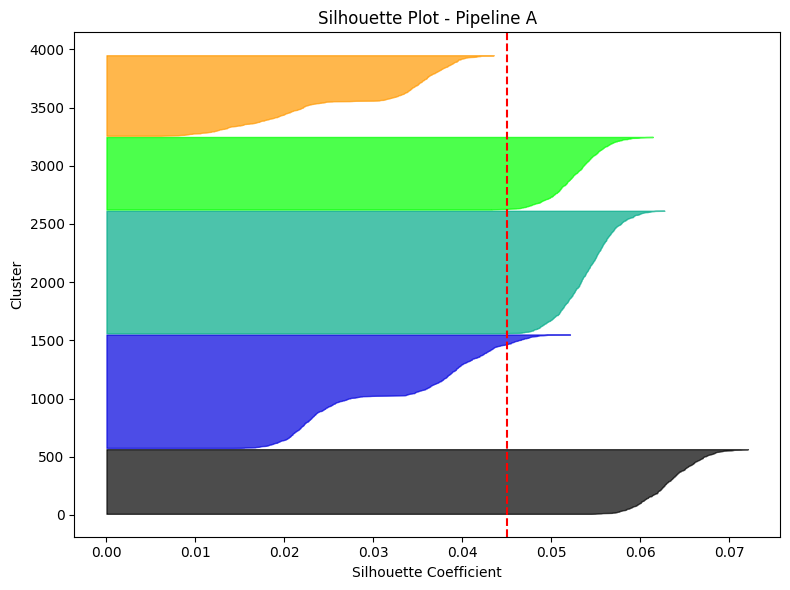

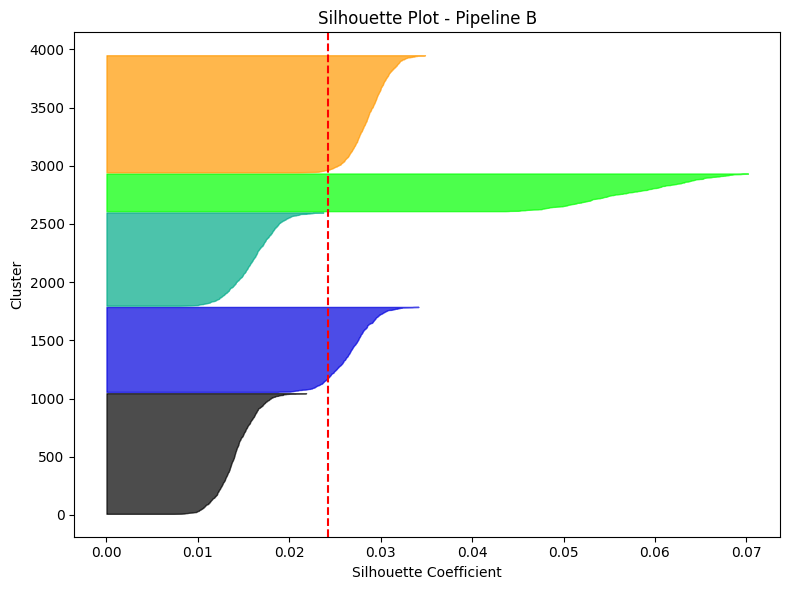

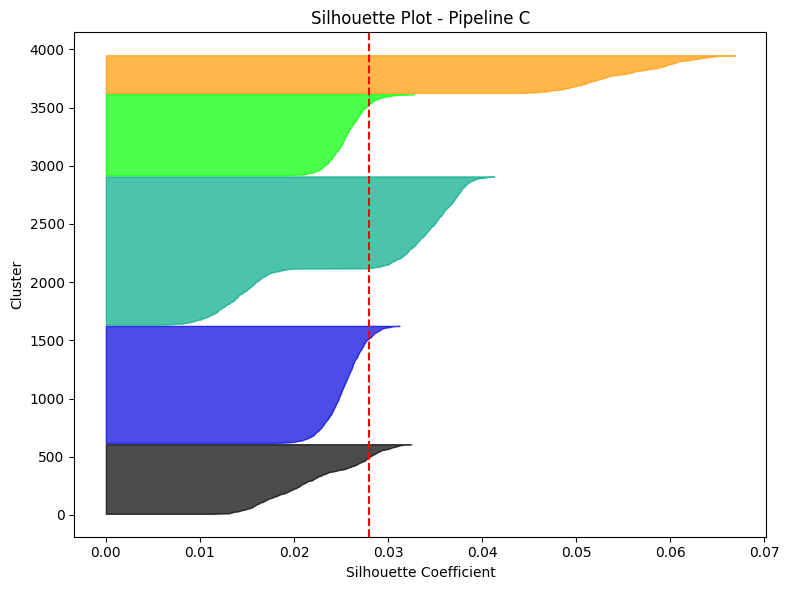

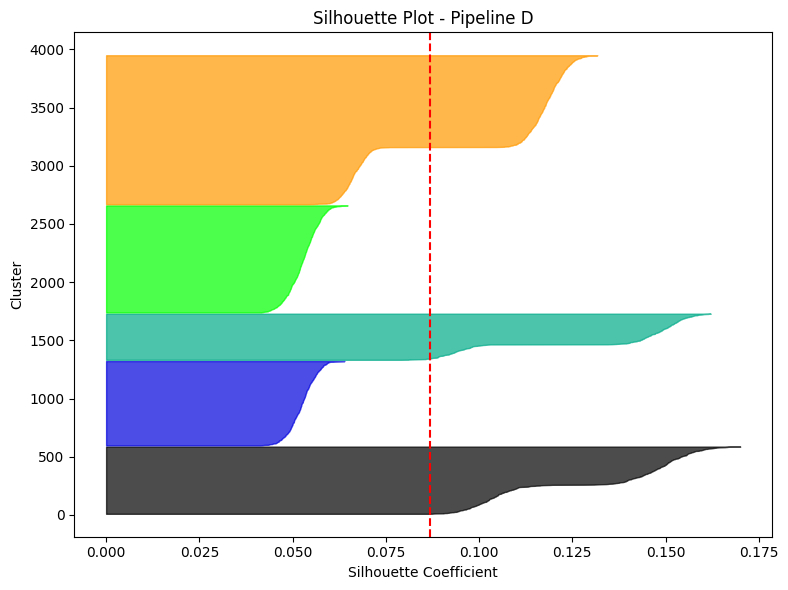

In [9]:
def plot_silhouette(data, labels, title):
    sil_vals = silhouette_samples(data, labels)
    y_lower = 10
    plt.figure(figsize=(8, 6))
    for i in np.unique(labels):
        ith_vals = sil_vals[labels == i]
        ith_vals.sort()
        size_i = ith_vals.shape[0]
        y_upper = y_lower + size_i
        color = plt.cm.nipy_spectral(float(i) / len(np.unique(labels)))
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_vals, facecolor=color, edgecolor=color, alpha=0.7)
        y_lower = y_upper + 10
    plt.title(f"Silhouette Plot - {title}")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Cluster")
    plt.axvline(x=np.mean(sil_vals), color="red", linestyle="--")
    plt.tight_layout()
    plt.show()

plot_silhouette(data_a, labels_a, "Pipeline A")
plot_silhouette(data_b, labels_b, "Pipeline B")
plot_silhouette(data_c, labels_c, "Pipeline C")
plot_silhouette(data_d, labels_d, "Pipeline D")


Elbow Method

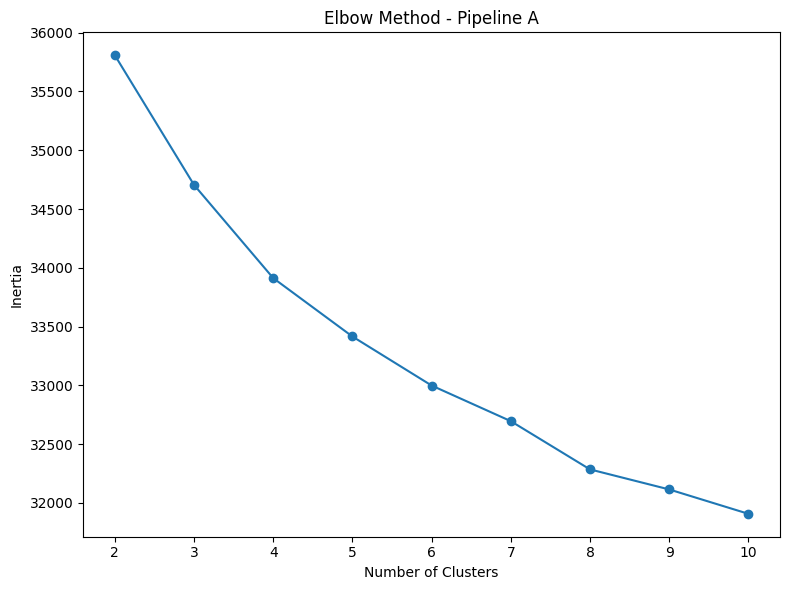

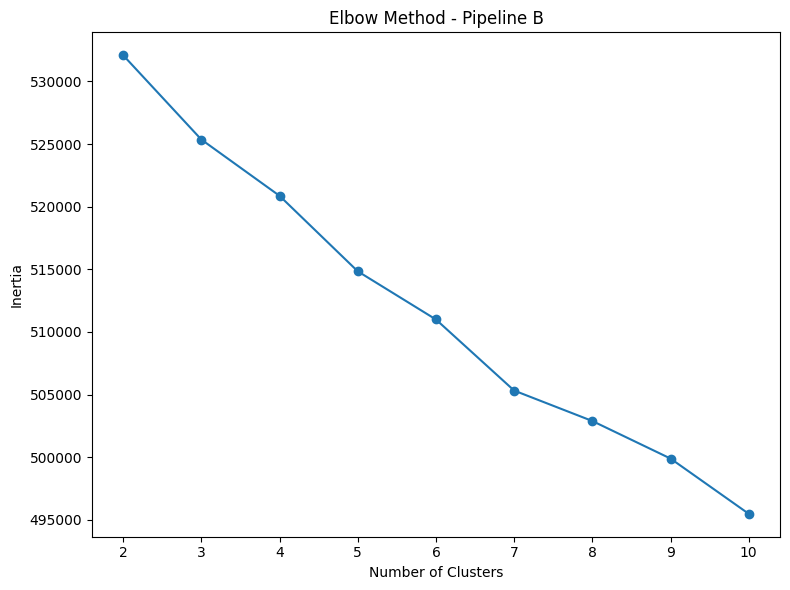

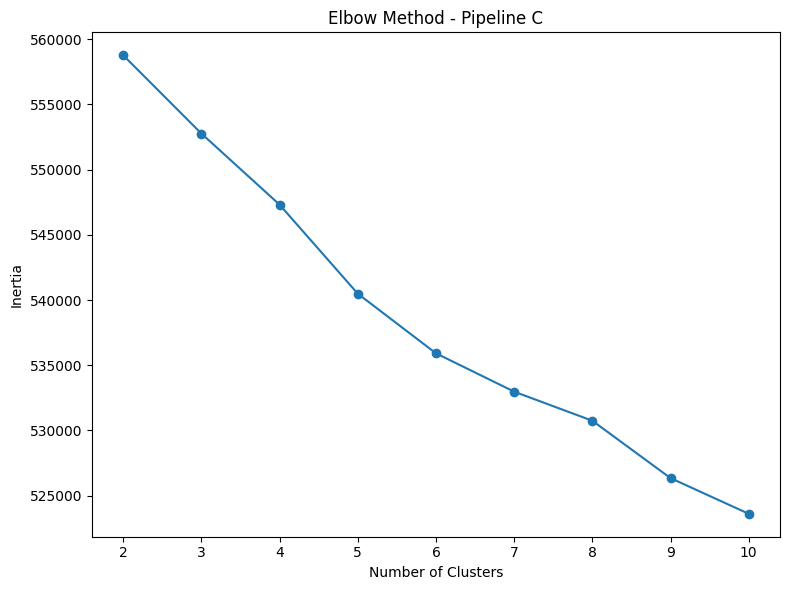

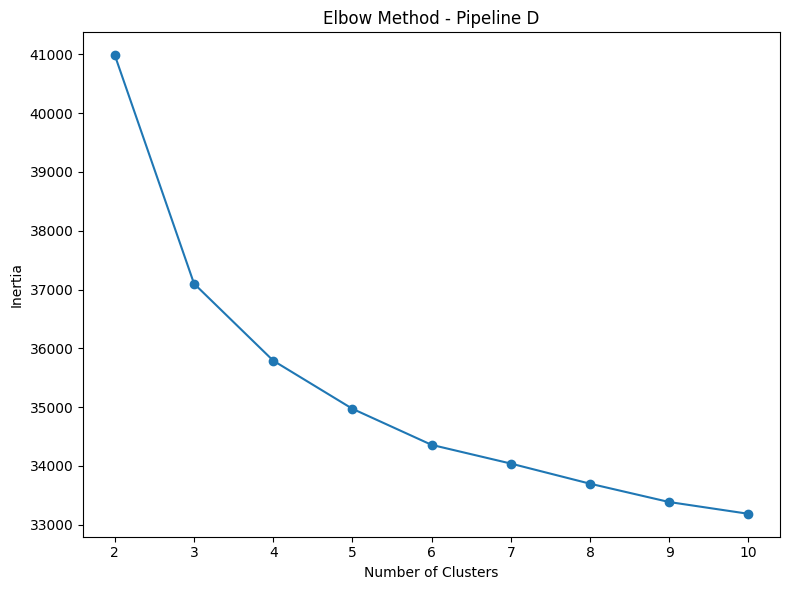

In [10]:
def plot_elbow(data, title):
    inertias = []
    for k in range(2, 11):
        km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(data)
        inertias.append(km.inertia_)
    plt.figure(figsize=(8, 6))
    plt.plot(range(2, 11), inertias, marker='o')
    plt.title(f"Elbow Method - {title}")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.tight_layout()
    plt.show()

plot_elbow(data_a, "Pipeline A")
plot_elbow(data_b, "Pipeline B")
plot_elbow(data_c, "Pipeline C")
plot_elbow(data_d, "Pipeline D")



Metric Comparison Bar Chart

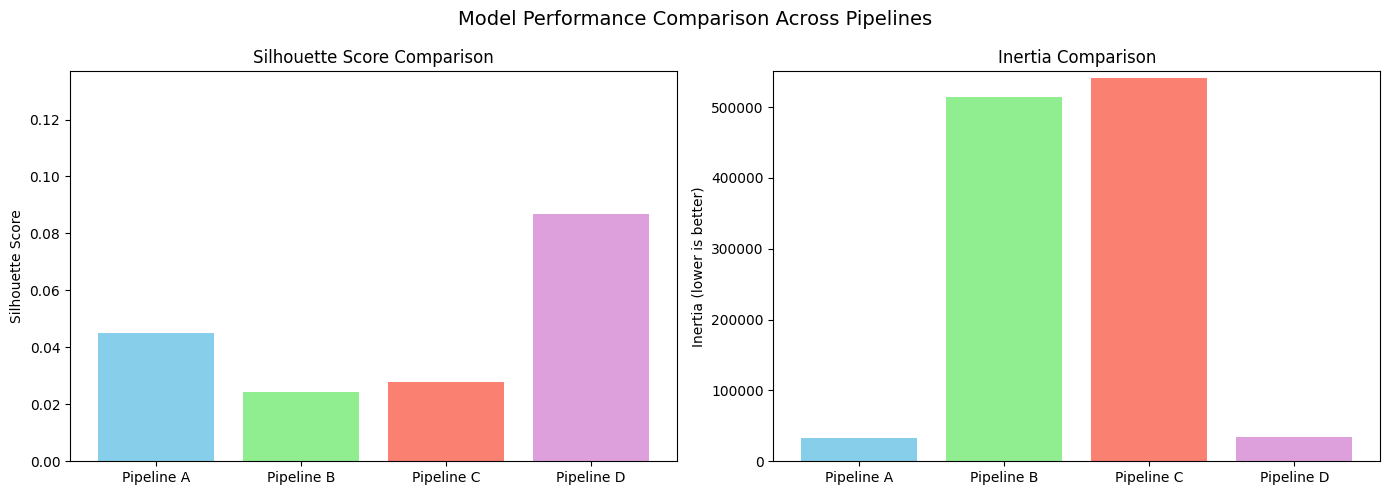

In [11]:
def plot_comparison_bars(silhouettes, inertias, pipeline_labels):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Silhouette Score Bar Chart
    ax[0].bar(pipeline_labels, silhouettes, color=['skyblue', 'lightgreen', 'salmon', 'plum'])
    ax[0].set_title("Silhouette Score Comparison")
    ax[0].set_ylabel("Silhouette Score")
    ax[0].set_ylim(0, max(silhouettes) + 0.05)

    # Inertia Bar Chart
    ax[1].bar(pipeline_labels, inertias, color=['skyblue', 'lightgreen', 'salmon', 'plum'])
    ax[1].set_title("Inertia Comparison")
    ax[1].set_ylabel("Inertia (lower is better)")
    ax[1].set_ylim(0, max(inertias) + 10000)

    plt.suptitle("Model Performance Comparison Across Pipelines", fontsize=14)
    plt.tight_layout()
    plt.show()

# Define values
silhouette_scores = [silhouette_a, silhouette_b, silhouette_c, silhouette_d]
inertia_scores = [inertia_a, inertia_b, inertia_c, inertia_d]
pipeline_names = ["Pipeline A", "Pipeline B", "Pipeline C", "Pipeline D"]

# Plot
plot_comparison_bars(silhouette_scores, inertia_scores, pipeline_names)

